# Imports

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from typing import Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import functools
import matplotlib.pyplot as plt
import math
Batch = Mapping[str, np.ndarray]

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3ux8hihn because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Functions

## General

In [4]:
def load_dataset(dataset: str, split: str, *, is_training: bool, 
                 batch_size: int) -> Generator[Batch, None, None]:

    if dataset == "cifar10":
        ds = tfds.load("cifar10", split=split).cache().repeat()
    elif dataset == "mnist":
        ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    else:
        raise Exception("Invalid Dataset")
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))

def get_mnist_data(batch_size=1000):
    train = load_dataset("mnist", "train", is_training=True, batch_size=batch_size)
    train_eval = load_dataset("mnist", "train", is_training=False, batch_size=batch_size)
    test_eval = load_dataset("mnist", "test", is_training=False, batch_size=batch_size)
    return train, train_eval, test_eval

    

def softmax_xent_loss(net):
    """
    Params:
        net: network function (with apply and init funcs)
    
    Returns:
        loss_fn: function(params, batch) --> loss
        
    Creates softmax cross entropy loss function for a given network
    """
    @jax.jit
    def loss(params, batch):
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(batch["label"], 10)

        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]

        return softmax_xent + 1e-4 * l2_loss
    
    return loss 


def ptwise_grads(loss_fn):
    """
    Params:
        loss_fn: function(params, batch) --> loss 
    
    Returns:
        function(params, batch) --> pointwise gradients
    
    """
    
    def helper(params, batch):
        batch['image'] = jnp.expand_dims(batch['image'], axis=0)
        batch['label'] = jnp.expand_dims(batch['label'], axis=0)
        return jax.grad(loss_fn)(params, batch)
    
    return jax.jit(jax.vmap(helper, in_axes=(None, {'image': 0, 'label': 0}), out_axes=0))


# Returns both network and loss given net function so as to not mistakenly use incompatible functions
def network_and_loss(net_fn, rng=False):
    if not rng:
        net = hk.without_apply_rng(hk.transform(net_fn))
    else:
        net = hk.transform(net_fn)
        
    loss_fn = softmax_xent_loss(net)
    
    return net, loss_fn
    
    
    
    


## Network Architectures

In [5]:
def net_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch["image"].astype(jnp.float32) / 255.
    mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(10),
    ])
    return mlp(x)


def net_fn_cnn(batch: jnp.ndarray) -> jnp.ndarray:
    """Vanilla CNN for MNIST"""
    x = batch["image"].astype(jnp.float32) / 255.
    cnn = hk.Sequential([
      hk.Conv2D(24,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Conv2D(48,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Flatten(),
      hk.Linear(10),
    ])
    return cnn(x)

def deeper_cnn(batch: jnp.ndarray) -> jnp.ndarray:
    """Slightly deeper CNN for MNIST"""
    x = batch["image"].astype(jnp.float32) / 255.
    cnn = hk.Sequential([
        hk.Conv2D(24,5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Conv2D(48,5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Conv2D(64, 5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Flatten(),
        hk.Linear(10),
    ])
    return cnn(x)

def deepest_cnn(batch: jnp.ndarray) -> jnp.ndarray:
    """Slightly deeper CNN for MNIST"""
    x = batch["image"].astype(jnp.float32) / 255.
    cnn = hk.Sequential([
        hk.Conv2D(24,5), jax.nn.relu,
        hk.Conv2D(24,5), jax.nn.relu,
        hk.Conv2D(24,5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Conv2D(48,5), jax.nn.relu,
        hk.Conv2D(48, 5), jax.nn.relu,
        hk.Conv2D(48, 5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Conv2D(96, 5), jax.nn.relu,
        hk.Conv2D(96, 5), jax.nn.relu,
        hk.Conv2D(96, 5), jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
        hk.Flatten(),
        hk.Linear(10),
    ])
    return cnn(x)


## Training

In [6]:
def net_accuracy(net):  
    @jax.jit
    def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])
    return accuracy



def update_params(loss_fn):   
    @jax.jit
    def update(
      params: hk.Params,
      opt_state: optax.OptState,
      batch: Batch,
    ) -> Tuple[hk.Params, optax.OptState]:
        grads = jax.grad(loss_fn)(params, batch)
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state
    return update

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation (cf. https://doi.org/10.1137/0330046)
@jax.jit
def ema_update(params, avg_params):
    return optax.incremental_update(params, avg_params, step_size=0.001)

def do_training(net, loss_fn, params, opt_state, train, train_eval, test_eval, epochs=10001, print_epoch=1000):

    accuracy = net_accuracy(net)
    update = update_params(loss_fn)
    avg_params = params
    
    # Train/eval loop.
    for step in range(epochs):
        if step % print_epoch == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            train_accuracy = accuracy(avg_params, next(train_eval))
            test_accuracy = accuracy(avg_params, next(test_eval))
            train_accuracy, test_accuracy = jax.device_get(
              (train_accuracy, test_accuracy))
            print(f"[Step {step}] Train / Test accuracy: "
                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        params, opt_state = update(params, opt_state, next(train))
        avg_params = ema_update(params, avg_params)
    
    return avg_params

## Compute Distances

In [7]:
def ravel_pytree(pytree):
    leaves, treedef = jax.tree_flatten(pytree)
    batch_size = leaves[0].shape[0]
    return jnp.concatenate([jnp.reshape(elt,(batch_size,-1)) for elt in leaves],axis=1)

def avg_sim(features,labels,classes,seq,num_iters=1000):
    
    n_classes = len(classes)
    counts = np.zeros(shape=(n_classes,n_classes))
    totals = np.zeros(shape=(n_classes,n_classes))
    
    batch_size = features.shape[0]
    
    for _ in range(num_iters):
    
        
        # sample two points, dot them
        [i,j]  = random.choice(next(seq),np.arange(batch_size),shape=(2,),replace=False)
        prod = jnp.dot(features[i],features[j])
        
        indi = classes.index(labels[i])
        indj = classes.index(labels[j])
        
        totals[indi,indj] += prod
        counts[indi,indj] += 1
    
    totals = (totals + totals.T)/2
    counts = (counts + counts.T)/2
    print(counts)
    

    return totals/counts


def new_avg_sim(loss, params, batch, seq, num_iters=100, minibatch_size=10):
    
    classes = list(range(10))
    n_classes = len(classes)
    counts = np.zeros(shape=(n_classes,n_classes))
    totals = np.zeros(shape=(n_classes,n_classes))
    batch_size = batch['image'].shape[0]
    
    for _ in range(num_iters):
        # 1) randomly select minibatch of size minibatch_size
        # 2) compute pointwise gradients for each sample in minibatch
        # 3) compute pairwise inner products between all pointwise gradients in minibatch
        
        # (1)
        batch_selection = np.arange(batch_size)
        minibatch_idx = random.choice(next(seq), batch_selection, shape=(minibatch_size,), replace=False)
        minibatch = jnp.take(batch['image'], minibatch_idx, axis=0)
        minibatch_labels = jnp.take(batch['label'], minibatch_idx, axis=0)
        
        # (2)
        compute_pointwise_grads = ptwise_grads(loss)
        pointwise_grads = compute_pointwise_grads(params, {'image': minibatch, 'label': minibatch_labels})
        
        # (3)
        features = ravel_pytree(pointwise_grads)
        for i in range(minibatch_size):
            for j in range(minibatch_size):
                if j >= i:
                    continue
                prod = jnp.dot(features[i], features[j])
                
                indi = classes.index(minibatch_labels[i])
                indj = classes.index(minibatch_labels[j])
                
                totals[indi,indj] += prod
                counts[indi,indj] += 1
                
    # (4)
    totals = (totals + totals.T)/2
    counts = (counts + counts.T)/2
    print(counts)
    

    return totals/counts
   
            
        
    

def compute_distances(loss, params, batch, iters=1000, prng_seq=None):
    compute_pointwise_gradients = ptwise_grads(loss)
    pointwise_gradients = compute_pointwise_gradients(params, batch)
    return avg_sim(ravel_pytree(pointwise_gradients), batch['label'], 
                   list(range(10)), prng_seq if prng_seq else hk.PRNGSequence(42), num_iters=iters)

# Do Stuff

# Training loop

In [ ]:
# load mnist data
train, train_eval, test_eval = get_mnist_data()

# cnn, loss, params
cnn, xent_loss = network_and_loss(net_fn_cnn)
params = cnn.init(jax.random.PRNGKey(42), next(train))

# optimization of network
opt = optax.adam(1e-3)
opt_state = opt.init(params)

# train cnn
final_params = do_training(cnn, xent_loss, params, opt_state, train, train_eval, test_eval, epochs=1001)

## Gradient distances

In [ ]:
# single, constant batch for replicable results
train = load_dataset("mnist", "train", is_training=True, batch_size=1000)
batch = next(train)

In [ ]:
t_initial_distances = compute_distances(xent_loss, params, batch)
t_final_distances = compute_distances(xent_loss, final_params, batch)

In [ ]:
# initial distances
plt.imshow(t_initial_distances)
plt.colorbar()

In [ ]:
# final distances
plt.imshow(t_final_distances)
plt.colorbar()

## Deeper network

In [ ]:
train, train_eval, test_eval = get_mnist_data()
batch = next(train)
batch = next(train)

deep_cnn, loss = network_and_loss(deeper_cnn)
params = deep_cnn.init(jax.random.PRNGKey(34), next(train))
print(batch['image'].shape)

In [ ]:
distances = compute_distances(loss, params, batch, 7000)
plt.imshow(distances)
plt.colorbar()

## Even Deeper

Note: For larger networks with more parameters, it will be infeasible to store all of the pointwise gradients at the same time. Instead we will have to perform the pointwise gradient computation on minibatches of a given batch.

In [ ]:
# Even deeper
train, train_eval, test_eval = get_mnist_data(1000)
batch = next(train)


cnn, loss = network_and_loss(deepest_cnn)
params = cnn.init(jax.random.PRNGKey(2), next(train))

In [ ]:
distances = new_avg_sim(loss, params, batch, hk.PRNGSequence(42), num_iters=100)

In [ ]:
plt.imshow(distances)
plt.colorbar()

In [ ]:
opt = optax.adam(1e-3)
opt_state = opt.init(params)

final_params = do_training(cnn, loss, params, opt_state, train, train_eval, test_eval, epochs=3001)

# Playground

In [6]:
# TODO
# Run multiple colobars while varying batch and initial params
# Implement paper to reduce dimension while preserving dot product


In [7]:
## Initialize deep cnn
train, train_eval, test_eval = get_mnist_data(1000)
batch = next(train)
cnn, loss = network_and_loss(deepest_cnn)
params = cnn.init(jax.random.PRNGKey(2), next(train))

# out of memory error, two many network parameters to compute 1000 pointwise gradients at once
# pointwise_gradients = ptwise_grads(loss)(params, batch)
# gradient_features = ravel_pytree(pointwise_gradients)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /home/jovyan/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [15]:
## Couple methods for going about this:
    # for each point, compute pointwise gradient then reduce dimension
    # Compute pointwise gradients in minibatches and reduce dimension
    

def Achlio_matrix(large_dim, small_dim, prng_key):
    print(large_dim)
    mat =  random.choice(prng_key, np.array([-1, 0, 1]), 
                         shape=(large_dim,), p=np.array([1./6., 2./3., 1./6.]), replace=True)
    return jnp.sqrt(3)*mat
    

def features_for_point(loss):
    

    def helper(batch, params):
        point = {}
        point['image'] = jnp.expand_dims(batch['image'], axis=0)
        point['label'] = jnp.expand_dims(batch['label'], axis=0)
        gradient = jax.grad(loss)(params, point)
        leaves, _ = jax.tree_flatten(gradient)
        features = jnp.concatenate([jnp.reshape(elt, -1) for elt in leaves], axis=0)
        return features
    return helper
    

        

In [16]:
@jax.jit
def one_feature(key, old_features):
    vec = jnp.ravel(Achlio_matrix(old_features.shape[0],1, key))
    return jnp.dot(vec, old_features)

def all_features(loss, params):

    def helper(keys, single_point):
        old_features = features_for_point(loss)(single_point, params)
        return jnp.array([one_feature(keys[i], old_features) for i in range(1000)])
    return helper

def new_all_features(loss, params):
    @jax.jit
    def helper(keys, single_point):
        old_features = features_for_point(loss)(single_point, params)
        @jax.jit
        def f(carry, key):
            return carry, one_feature(key, old_features)
        _, res = jax.lax.scan(f, None, keys)
        return res
    return helper

def all_points_in_batch(loss, params):
    @jax.jit
    def helper(keys, batch):
        compute_one_features = new_all_features(loss, params)
        @jax.jit
        def f(carry, point):
            return carry, compute_one_features(keys, point)
        _, res = jax.lax.scan(f, None, batch)
        return res
    return helper

def get_keys(seq, num_keys):
    return jnp.array([next(seq) for i in range(num_keys)])

## Try with different number of features

In [50]:
# jit
func = all_points_in_batch(loss, params)
seq = hk.PRNGSequence(42)
def get_keys(seq, num_keys):
    return jnp.array([next(seq) for i in range(num_keys)])
keys = get_keys(seq, 200)

In [51]:
compute_final_features = all_points_in_batch(loss, params)
final_features = compute_final_features(keys, batch)

758554


In [52]:
final_features = final_features*jnp.sqrt(1./200)

In [53]:
distances = avg_sim(final_features, batch['label'], list(range(10)), hk.PRNGSequence(42))

[[ 7.  12.  13.  10.5 12.   4.5 10.5  9.  11.  10.5]
 [12.  12.   9.5 14.  12.   6.   9.  11.5 16.5 12.5]
 [13.   9.5  6.   8.5 11.5 11.   6.5 12.  13.5 12.5]
 [10.5 14.   8.5 16.   7.   8.   9.5 13.   7.  12.5]
 [12.  12.  11.5  7.   9.   9.   5.  13.  11.5  9.5]
 [ 4.5  6.  11.   8.   9.   4.   6.   5.5  7.5  8.5]
 [10.5  9.   6.5  9.5  5.   6.   6.  11.   9.5 10. ]
 [ 9.  11.5 12.  13.  13.   5.5 11.  14.  10.  13. ]
 [11.  16.5 13.5  7.  11.5  7.5  9.5 10.   7.   8. ]
 [10.5 12.5 12.5 12.5  9.5  8.5 10.  13.   8.  12. ]]


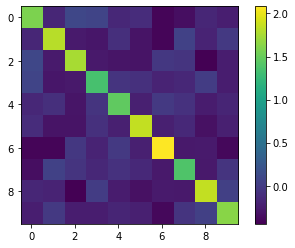

In [54]:
plt.imshow(distances)
plt.colorbar()

In [23]:
flattened_params, _ = jax.tree_flatten(jax.grad(loss)(params, batch))

In [26]:
jnp.concatenate([jnp.reshape(elt, -1) for elt in flattened_params], axis=0).shape

(758554,)

## Old, small network to compare the two methods

In [55]:
## Initialize deep cnn
train, train_eval, test_eval = get_mnist_data(1000)
batch = next(train)
cnn, loss = network_and_loss(net_fn_cnn)
params = cnn.init(jax.random.PRNGKey(2), next(train))

In [56]:
og_features = ptwise_grads(loss)(params, batch)

In [58]:
flattened = ravel_pytree(og_features)

In [60]:
flattened.shape

(1000, 53002)

In [61]:
distances = avg_sim(flattened, batch['label'], list(range(10)), hk.PRNGSequence(42))

[[ 7.  12.  13.  10.5 12.   4.5 10.5  9.  11.  10.5]
 [12.  12.   9.5 14.  12.   6.   9.  11.5 16.5 12.5]
 [13.   9.5  6.   8.5 11.5 11.   6.5 12.  13.5 12.5]
 [10.5 14.   8.5 16.   7.   8.   9.5 13.   7.  12.5]
 [12.  12.  11.5  7.   9.   9.   5.  13.  11.5  9.5]
 [ 4.5  6.  11.   8.   9.   4.   6.   5.5  7.5  8.5]
 [10.5  9.   6.5  9.5  5.   6.   6.  11.   9.5 10. ]
 [ 9.  11.5 12.  13.  13.   5.5 11.  14.  10.  13. ]
 [11.  16.5 13.5  7.  11.5  7.5  9.5 10.   7.   8. ]
 [10.5 12.5 12.5 12.5  9.5  8.5 10.  13.   8.  12. ]]


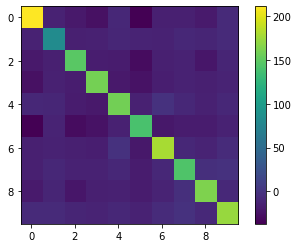

In [62]:
plt.imshow(distances)
plt.colorbar()

In [63]:
func = all_points_in_batch(loss, params)
seq = hk.PRNGSequence(42)
keys = get_keys(seq, 200)

In [64]:
compute_final_features = all_points_in_batch(loss, params)
final_features = compute_final_features(keys, batch)

53002


In [67]:
distances = avg_sim(jnp.sqrt(1./200)*final_features, batch['label'], list(range(10)), hk.PRNGSequence(42))

[[ 7.  12.  13.  10.5 12.   4.5 10.5  9.  11.  10.5]
 [12.  12.   9.5 14.  12.   6.   9.  11.5 16.5 12.5]
 [13.   9.5  6.   8.5 11.5 11.   6.5 12.  13.5 12.5]
 [10.5 14.   8.5 16.   7.   8.   9.5 13.   7.  12.5]
 [12.  12.  11.5  7.   9.   9.   5.  13.  11.5  9.5]
 [ 4.5  6.  11.   8.   9.   4.   6.   5.5  7.5  8.5]
 [10.5  9.   6.5  9.5  5.   6.   6.  11.   9.5 10. ]
 [ 9.  11.5 12.  13.  13.   5.5 11.  14.  10.  13. ]
 [11.  16.5 13.5  7.  11.5  7.5  9.5 10.   7.   8. ]
 [10.5 12.5 12.5 12.5  9.5  8.5 10.  13.   8.  12. ]]


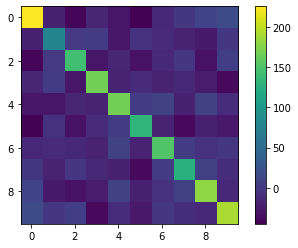

In [68]:
plt.imshow(distances)
plt.colorbar()

What's good about the above is that the magnitudes of the "reduced" inner products match the magnitudes of the "true" ones. Next, we follow Robert's suggestion and compute the variance between the inner products.

To compute the variance, we will do the following:
- compute the gradient features (batch_size x num_params)
- compute the reduced dimension features (bath_size x dim)
- compute pairwise inner products for both (batch_size x batch_size)
- take the difference between these two matrices and calculate mean and variance

### Compute true gradient features

In [10]:
train, train_eval, test_eval = get_mnist_data(1000)
batch = next(train)
cnn, loss = network_and_loss(net_fn_cnn)
params = cnn.init(jax.random.PRNGKey(2), next(train))

In [11]:
og_features = ptwise_grads(loss)(params, batch)
flattened = ravel_pytree(og_features)
flattened.shape

(1000, 53002)

### Compute reduced dimension features (200, 500, 1000)

In [44]:
compute_final_features = all_points_in_batch(loss, params)


seq = hk.PRNGSequence(24)
small_keys = get_keys(seq, 200)
med_keys = get_keys(seq, 500)
large_keys = get_keys(seq, 1000)

In [45]:
small_final_features = jnp.sqrt(1./200)*compute_final_features(small_keys, batch)
med_final_features = jnp.sqrt(1./500)*compute_final_features(med_keys, batch)
large_final_features = jnp.sqrt(1./1000)*compute_final_features(large_keys, batch)

53002
53002
53002


### Compute pairwise inner products for both sets of features

In [26]:
def inner(x, y):
    return jnp.dot(x,y)

temp = jax.vmap(inner, in_axes=(0, None))
pairwise_products = jax.vmap(test, in_axes=(None, 0), out_axes=1)

In [46]:
og_pairwise = pairwise_products(flattened, flattened)
small_pairwise = pairwise_products(small_final_features, small_final_features)
med_pairwise = pairwise_products(med_final_features, med_final_features)
large_pairwise = pairwise_products(large_final_features, large_final_features)

small_diffs = small_pairwise - og_pairwise
med_diffs = med_pairwise - og_pairwise
large_diffs = large_pairwise - og_pairwise

### Compute mean and variance

In [68]:
# for reference: the "true" pairwise products are stored in "og_pairwise"
print("Max: {}, Min: {}".format(jnp.max(og_pairwise), jnp.min(og_pairwise)))
print("Median: {}".format(jnp.median(og_pairwise)))
print("Mean: {}".format(jnp.mean(jnp.abs(og_pairwise))))

Max: 496.9286193847656, Min: -91.12599182128906
Median: -12.06199836730957
Mean: 28.586336135864258


In [66]:
print(batch['label'])
og_pairwise[34][39]

[1 7 2 7 6 1 1 3 3 3 2 7 3 2 1 7 3 3 5 6 9 1 3 4 9 5 5 2 7 3 6 7 4 7 8 0 3
 1 4 8 9 5 4 2 1 4 3 6 2 8 4 1 4 8 8 2 0 7 3 0 6 4 8 1 3 3 5 1 6 9 5 0 2 0
 2 8 5 2 8 3 5 1 7 9 3 1 7 6 0 9 8 7 2 7 7 2 1 7 0 6 0 1 6 1 2 8 0 8 5 6 0
 4 9 6 3 3 6 4 3 9 9 9 1 2 3 4 9 1 9 0 2 6 4 4 0 8 8 1 3 4 6 0 7 9 3 9 2 4
 7 5 9 1 8 4 4 3 3 7 2 0 0 6 3 9 6 7 6 1 8 1 6 6 2 1 7 1 0 7 2 4 4 8 5 3 9
 3 1 9 6 8 5 7 4 5 2 8 1 3 0 2 7 1 4 7 2 7 4 2 4 7 0 0 4 7 6 1 3 2 1 6 6 1
 9 6 0 7 1 5 3 1 2 1 8 2 8 2 0 3 5 5 7 2 9 6 6 8 7 6 3 5 3 5 4 0 2 8 0 8 9
 0 7 6 0 4 2 6 4 7 0 3 1 7 7 0 2 7 2 0 3 0 0 5 4 3 0 0 3 3 1 3 0 0 3 3 9 9
 8 9 5 0 5 6 2 1 4 1 4 7 6 3 2 1 2 0 2 6 5 2 4 8 8 4 9 3 1 7 6 9 0 6 9 7 5
 0 5 7 5 2 2 5 5 9 1 9 9 6 7 9 3 7 0 9 9 5 9 0 4 8 0 2 4 7 7 9 6 0 7 3 8 3
 4 4 7 8 7 3 4 3 1 8 9 8 9 0 1 4 8 0 8 8 9 8 1 6 6 2 0 9 4 0 5 3 8 6 8 9 8
 5 3 6 3 0 3 6 3 9 3 6 2 6 1 3 6 6 2 3 1 0 6 5 6 7 7 9 2 7 9 4 4 0 4 8 7 2
 4 6 8 2 1 5 8 2 5 3 2 8 4 3 2 6 8 9 2 8 3 8 2 5 0 4 6 4 1 0 6 1 9 1 8 8 2
 5 3 4 1 1 3 1 7 6 0 5 2 

DeviceArray(168.765, dtype=float32)

200 features

In [49]:
print("Mean: {}".format(jnp.mean(small_diffs)))
print("Variance: {}".format(jnp.var(small_diffs)))
print("Std dev: {}".format(jnp.std(small_diffs)))

Mean: 0.18189573287963867
Variance: 246.5001983642578
Std dev: 15.700325012207031


500 features

In [50]:
print("Mean: {}".format(jnp.mean(med_diffs)))
print("Variance: {}".format(jnp.var(med_diffs)))
print("Std dev: {}".format(jnp.std(med_diffs)))

Mean: -0.0737052783370018
Variance: 112.04792022705078
Std dev: 10.585269927978516


1000 features

In [51]:
print("Mean: {}".format(jnp.mean(large_diffs)))
print("Variance: {}".format(jnp.var(large_diffs)))
print("Std dev: {}".format(jnp.std(large_diffs)))

Mean: -0.02094210684299469
Variance: 48.74789810180664
Std dev: 6.981969356536865


# NTK

In [9]:
@jax.jit
def one_feature(key, old_features):
    vec = jnp.ravel(Achlio_matrix(old_features.shape[0],1, key))
    return jnp.dot(vec, old_features)


@jax.jit
def new_features(keys, old_features):
    @jax.jit
    def f(carry, key):
        return carry, one_feature(key, old_features)
    _, res = jax.lax.scan(f, None, keys)
    return res


@jax.jit
def all_new_features(keys, batch):
    @jax.jit
    def f(carry, point):
        return carry, new_features(keys, point)
    _, res = jax.lax.scan(f, None, batch)
    return res


def get_keys(seq, num_keys):
    return jnp.array([next(seq) for i in range(num_keys)])

In [26]:
from jax import jacrev
from tqdm.notebook import tqdm

num_points = 10000
num_features = 10000
batch_size = 10
train = load_dataset('mnist', "train[0:{}]".format(num_points), is_training=True, batch_size=batch_size)
net, loss = network_and_loss(net_fn_cnn)
params = net.init(jax.random.PRNGKey(42), next(train))

all_reduced_features = np.zeros((num_points, num_features))

for idx, batch in tqdm(enumerate(train), total=num_points/batch_size, desc="Progress"):

    
    
    f = lambda params: net.apply(params,batch)
    J = jacrev(f)(params)
    features = ravel_pytree(J)
    keys = get_keys(hk.PRNGSequence(42), num_features)
    
    # dimension reduce
    %timeit new_features = all_new_features(keys, features)

    # move to cpu
    all_reduced_features[idx*batch_size:(idx+1)*batch_size] = new_features

    break

Progress:   0%|          | 0/1000.0 [00:00<?, ?it/s]

19.3 s ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
new_features.shape

(10, 10000)

In [19]:
train = load_dataset('mnist', "train[0:{}]".format(num_points), is_training=True, batch_size=batch_size)
params = net.init(jax.random.PRNGKey(42), next(train))
batch = next(train)
f = lambda params: net.apply(params,batch)
J = jacrev(f)(params)
keys = get_keys(hk.PRNGSequence(42), num_features)

[2]